## <u>Regridding .nc to N96</u>


July 2019

Import libraries

In [1]:
%load_ext autoreload
%autoreload

import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import iris
import iris.plot as iplt
import matplotlib.pyplot as plt
import numpy.ma as ma
%matplotlib inline
import cartopy.crs as ccrs
from   libs.plot_maps    import *
from netCDF4 import Dataset

Set variables

In [2]:
dir = '../data/driving_data2/'
dir_mask = '../data/n96_masked_data/'

files = {'vegcover'           : 'vegcover2000-2014.nc',
         'alphaMax'           : 'alpha_12monthMax2000-2014.nc',
         'alpha'              : 'alpha2000-2014.nc',
         'emc'                : 'emc2000-2014.nc',
         'treeCover'          : 'treecover2000-2014.nc',
         'lightning'          : 'lightning_ignitions2000-2014.nc',
         'pasture'            : 'pasture2000-2014.nc',
         'population_density' : 'population_density2000-2014.nc',
         'fire'               : 'fire2000-2014.nc',
         'cropland'           : 'cropland2000-2014.nc'}


# In order to use the mask file, the time variable must be removed:
# Remove '#' in comment below to run using linux terminal

# !ncks -x -v t ../data/n96e_orca1_mask.nc ../data/no_t_n96_mask.nc

mask_file2 = {'mask': 'no_t_n96_mask.nc'}

Loading in data

In [14]:
##open data

# files.items shows the name and the file of the entire dictionary. 'key' and 'file' sets the
# name and the file name respectively

input_data = {}
for key, file in files.items(): 
    data = iris.load_cube(dir + file)
    input_data[key] = data

    
# Check it has loaded:
print(input_data['vegcover'])

variable / (1)                      (time: 168; latitude: 360; longitude: 720)
     Dimension coordinates:
          time                           x              -               -
          latitude                       -              x               -
          longitude                      -              -               x
     Attributes:
          Conventions: CF-1.4
          Data from GFEDv4.1s: Raw data file list on data/gfed/file_list.txt
          Data obtained on: 2019-02-14 14:12:05
          created_by: R, packages ncdf4 and raster (version 2.6-7)
          date: 2019-07-05 13:33:09
          git Repository URL: https://github.com/douglask3/LimFIRE.git
          git Revision Number: c2e91e4
          git info by: gitBasedProjects 3.10
          max: [0.47235473 0.53642191 0.81430228 0.79855162 0.73440839 0.89358276
 0.82952994...
          min: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
...


In [4]:
# This doesn't work because iris.cube_load doesn't understand the file as no caldener time is specified
# Update: I've removed the time dimension and variable from the original masked NetCDF
# (Shouldn't make a difference, since there was only one layer of time)

data = iris.load_cube(dir_mask + mask_file2['mask'])
m_1 ={}
m_1['mask'] = data

print(m_1['mask'])

# Remove time and surface variable:
m = m_1['mask'][0,0,:,:]

# --------

# Instead try this if it doesn't work:
#dataset = Dataset(dir + mask_file['mask'])

# Look at dimensions (lat, lon) and variables (data)
#print(dataset.dimensions.keys())
#print(dataset.variables.keys())

#lsm = dataset.variables['lsm'][:]
#print(lsm.shape)

# dataset.close()


LAND MASK (No halo) (LAND=TRUE) / (unknown) (-- : 1; surface: 1; latitude: 144; longitude: 192)
     Dimension coordinates:
          surface                               -           x            -               -
          latitude                              -           -            x               -
          longitude                             -           -            -               x
     Attributes:
          NCO: 4.7.2
          date: 01/01/00
          history: Tue Jul 16 09:56:41 2019: ncks -C -x -v t n96e_orca1_mask.nc no_t_n96_mask.nc
Tue...
          name: lsm
          source: Unified Model Output (Vn 9.1):
          time: 00:00
          title: LAND MASK (No halo) (LAND=TRUE)
          valid_max: 1.0
          valid_min: 0.0


This plots the annual averages of the data, to make sure it looks sane

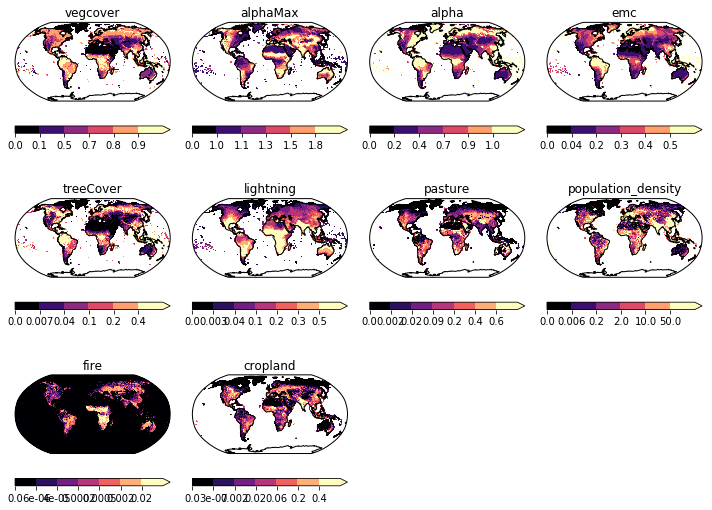

In [5]:
nd = 0

plt.figure(figsize = (10, 7.5))

for key, dat in input_data.items():
    nd = nd + 1
    dat = dat.collapsed('time', iris.analysis.MEAN)
    dat.long_name = key
    plot_lonely_cube(dat, 3, 4, nd, cmap = 'magma', levels = None)    

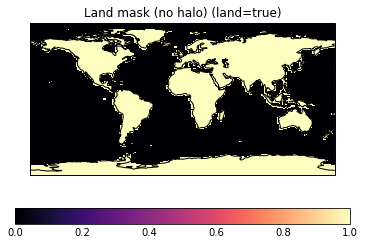

In [6]:
# Plotting lat, lon on mask

iplt.contourf(m, cmap = 'magma')
iris.quickplot.pcolormesh(m, cmap = 'magma')
plt.gca().coastlines()

Regridding one variable onto the mask

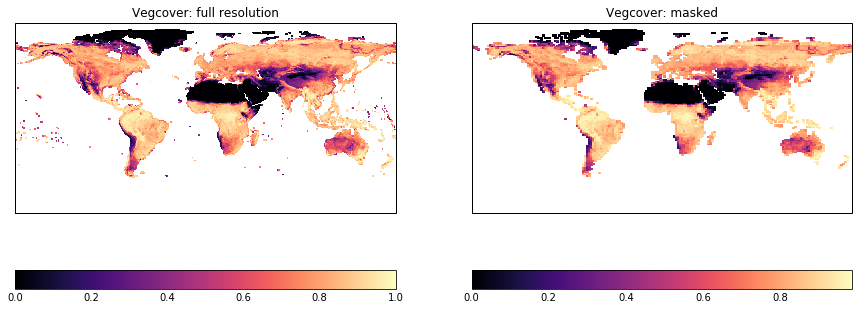

In [7]:
# Regrid
m_vegcover = input_data['vegcover'].regrid(m, iris.analysis.Linear())


# Make plots bigger
plt.rcParams['figure.figsize'] = [15, 7] # [height, width] in inches

# Plot original variable
plt.subplot(1, 2, 1)
iplt.contourf(input_data['vegcover'][0,:,:], cmap = 'magma')
iris.quickplot.pcolormesh(input_data['vegcover'][0,:,:], cmap = 'magma')
plt.title('Vegcover: full resolution')

# Plot masked variable
plt.subplot(1, 2, 2)
iplt.contourf(m_vegcover[0,:,:], cmap = 'magma')
iris.quickplot.pcolormesh(m_vegcover[0,:,:], cmap = 'magma')
plt.title('Vegcover: masked')

plt.show()

# Compare lon/lat lengths

#print(input_data['vegcover'])
#print(m_vegcover)

Regrid all variables

In [8]:
remasked_data = {}

for key in input_data.keys():
    dat = input_data[key].regrid(m, iris.analysis.Linear())
    remasked_data[key] = dat    

Plots to compare against original

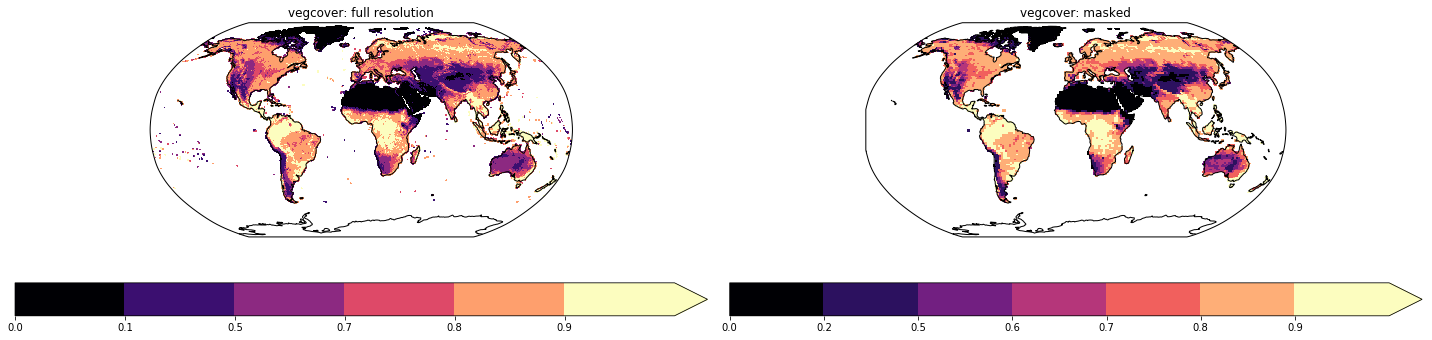

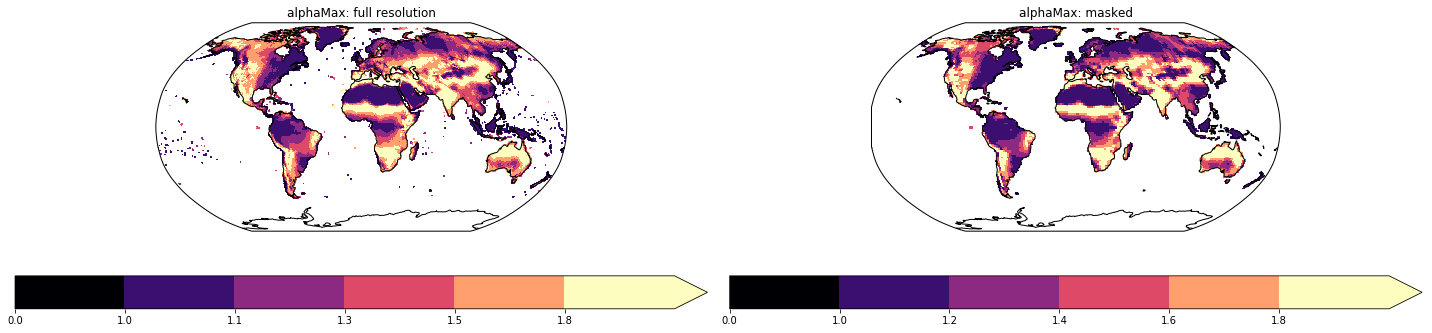

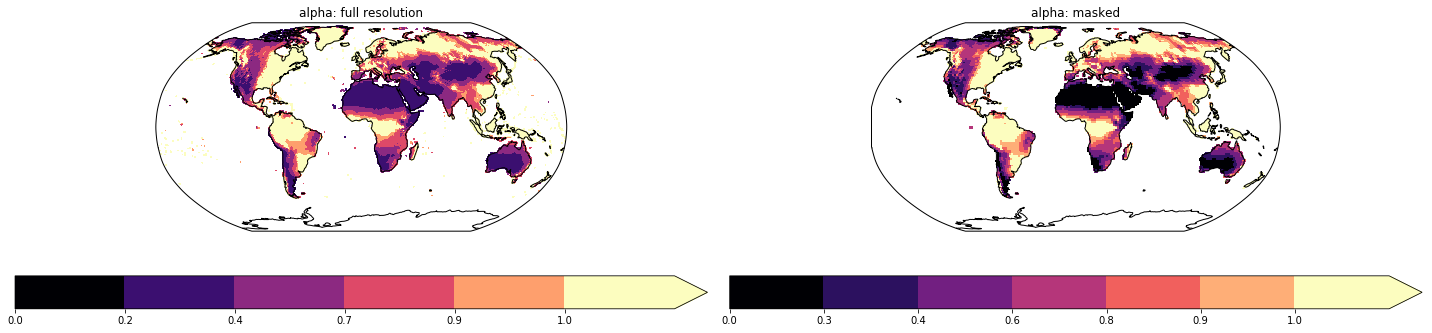

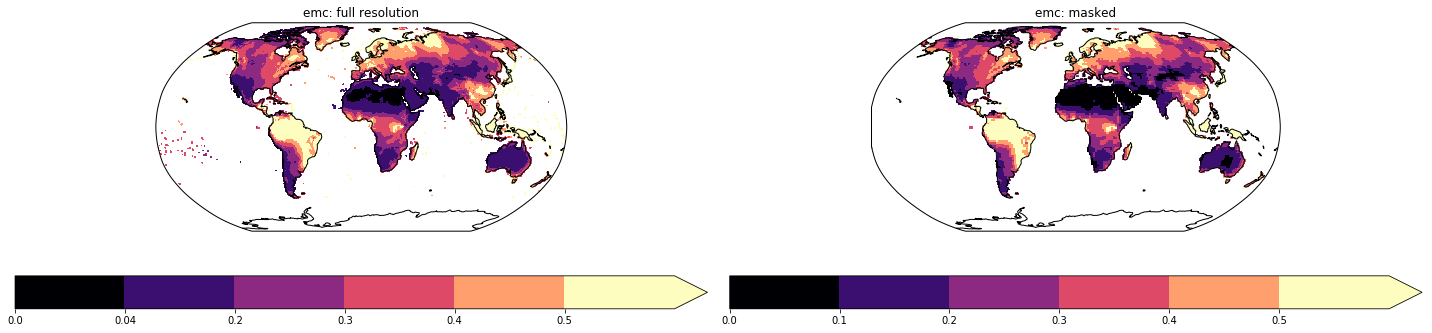

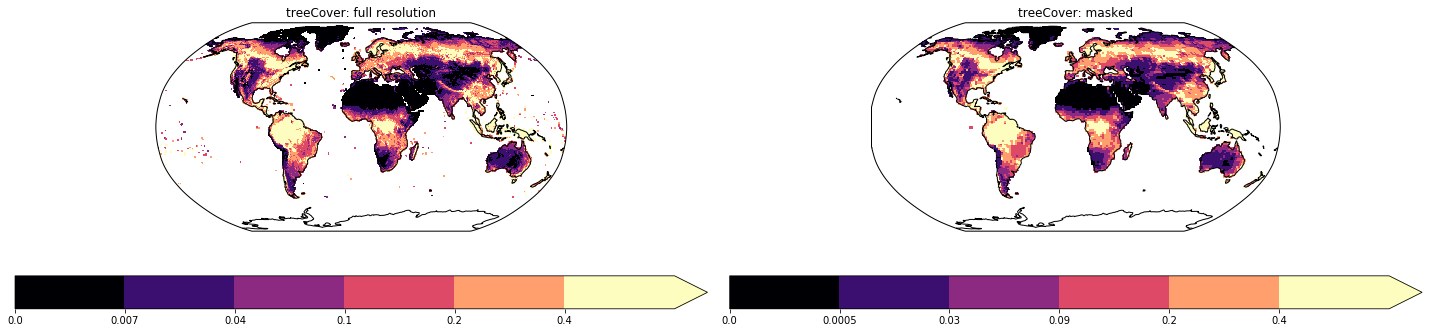

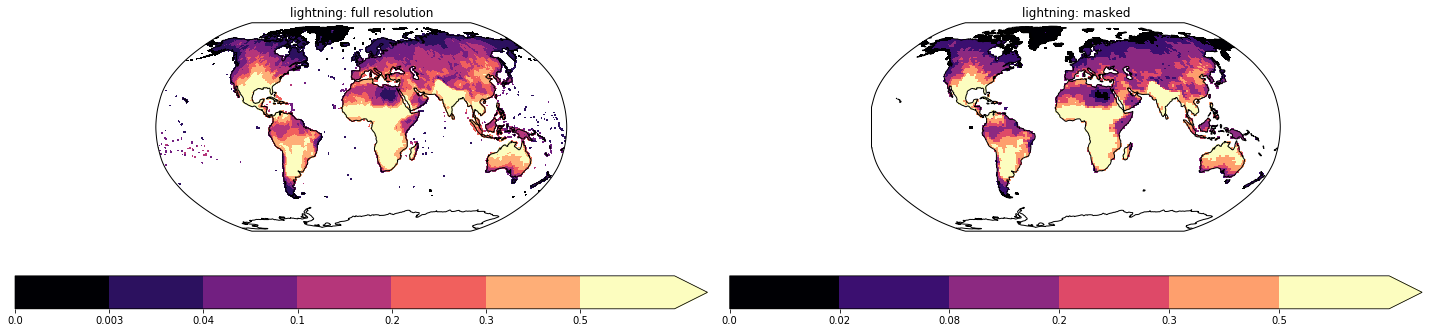

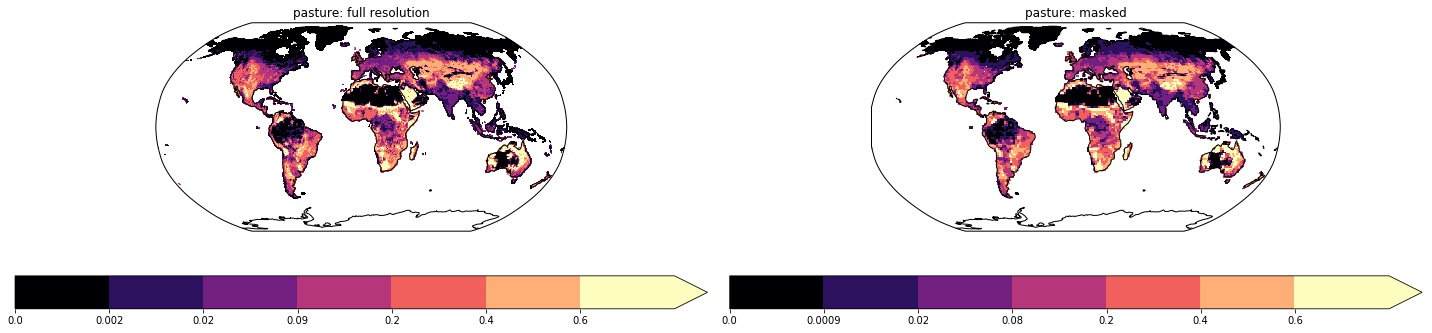

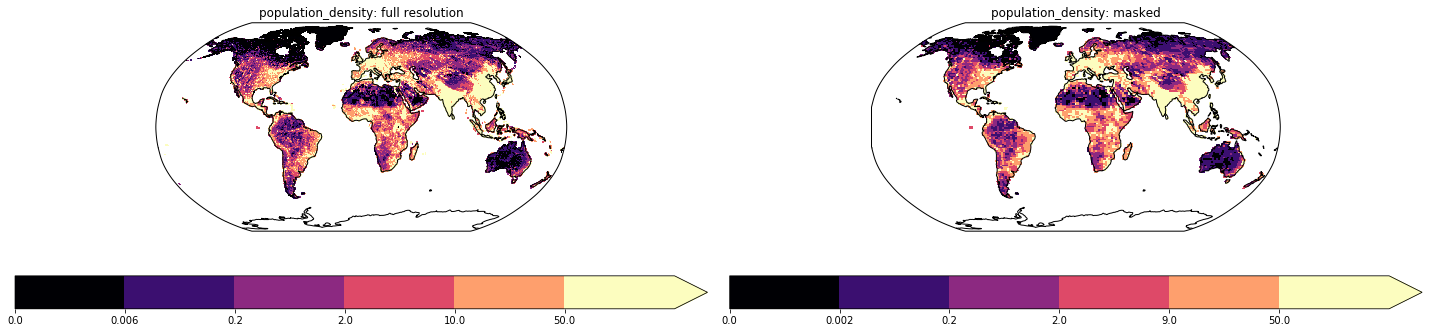

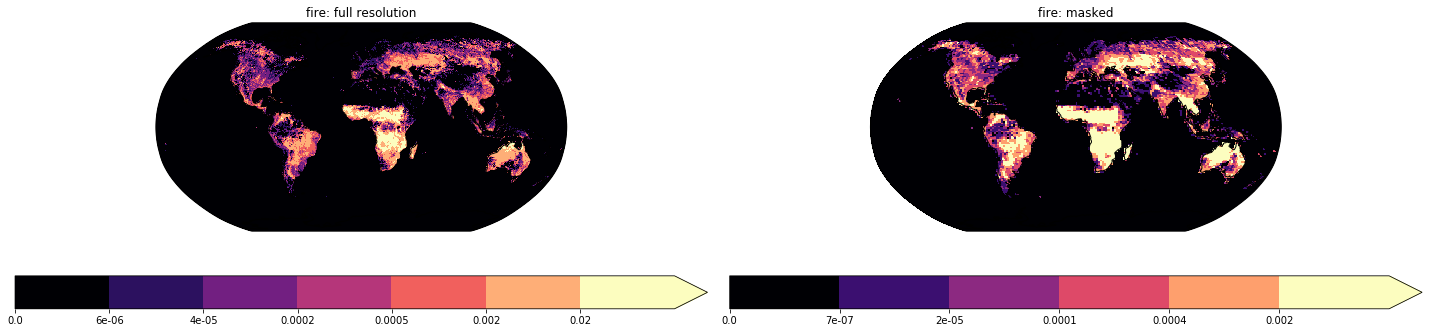

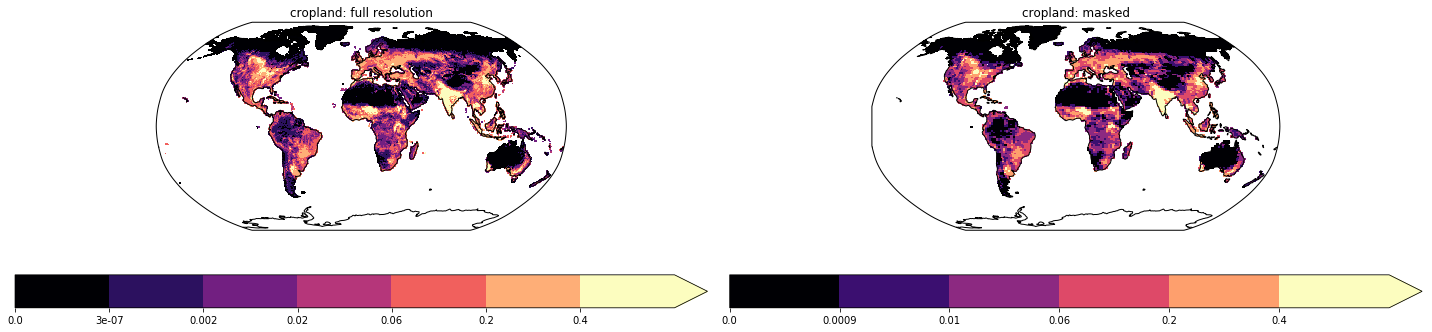

In [9]:
plt.rcParams['figure.figsize'] = [20, 45]

i = 1

for key in remasked_data.keys():
#    plt.subplot(1, 2, 1)
    dat1 = input_data[key].collapsed('time', iris.analysis.MEAN)
    plot_lonely_cube(dat1, len(remasked_data.keys()), 2, i, cmap = 'magma', levels = None)
    plt.title('%s: full resolution' %key)
    i = i + 1
    
#    plt.subplot(1, 2, 2)
    dat2 = remasked_data[key].collapsed('time', iris.analysis.MEAN)
    plot_lonely_cube(dat2, len(remasked_data.keys()), 2, i, cmap = 'magma', levels = None)
    plt.title('%s: masked' %key)
    plt.show()
    i = i + 1

Saving NetCDFs

In [13]:
for key, dat in remasked_data.items():
    new_file_names = files[key].replace(".nc","_masked.nc")
    out = '../data/n96_masked_data/outputs/' + new_file_names
    iris.save(dat, out)

In [15]:
print(remasked_data['fire'])

variable / (1)                      (time: 168; latitude: 144; longitude: 192)
     Dimension coordinates:
          time                           x              -               -
          latitude                       -              x               -
          longitude                      -              -               x
     Attributes:
          Conventions: CF-1.4
          Data from GFEDv4.1s: Raw data file list on data/gfed/file_list.txt
          Data obtained on: 2019-02-14 14:12:05
          created_by: R, packages ncdf4 and raster (version 2.6-7)
          date: 2019-07-05 13:33:09
          git Repository URL: https://github.com/douglask3/LimFIRE.git
          git Revision Number: c2e91e4
          git info by: gitBasedProjects 3.10
          max: [0.47235473 0.53642191 0.81430228 0.79855162 0.73440839 0.89358276
 0.82952994...
          min: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
...
